This is a notebook aiming to explore KNN graphs of image embeddings.

# 0. Import Dependencies
This notebook includes many functions in different files, feel free to explore them.

In [44]:
from PIL import Image

import numpy as np
import zipfile

### Embedding options ###
## VGG16 ##
from torch.utils.data import DataLoader
from dataset import ImageDataset
from torchvision import transforms
import torch
from torchvision import models

## Plotting ##
import matplotlib.pyplot as plt
import seaborn as sns

import random

random.seed(42) 
np.random.seed(42)
torch.manual_seed(42)


from get_embeddings import get_clip_embedding, get_normalised_histogram, get_embedding, get_embeddings_pytorch

from embeddings_analysis import get_knn, get_count_neighbour_occurances, rank_neighbour_occurances, get_mean_distance, get_cluster_labels

from force_directed_diagram import get_diagram_data #, get_position_df

from get_html import get_html_rendering_details, generate_html

# 1. Load images 

Please define the `.zip` file which contains your images (this may contain nested folders). You may also edit the `IMAGE_EXTENSIONS` if you wish to include/remove types.

In [3]:
# adjust these to desired values (Zip file images will be read from)
IMAGE_ZIP = "./images.zip"
IMAGE_EXTENSIONS = (".jpg", ".JPG", ".png",".PNG", ".JPEG", ".jpeg")

Example code for displaying an image from the zip file. The following code displays the first image.

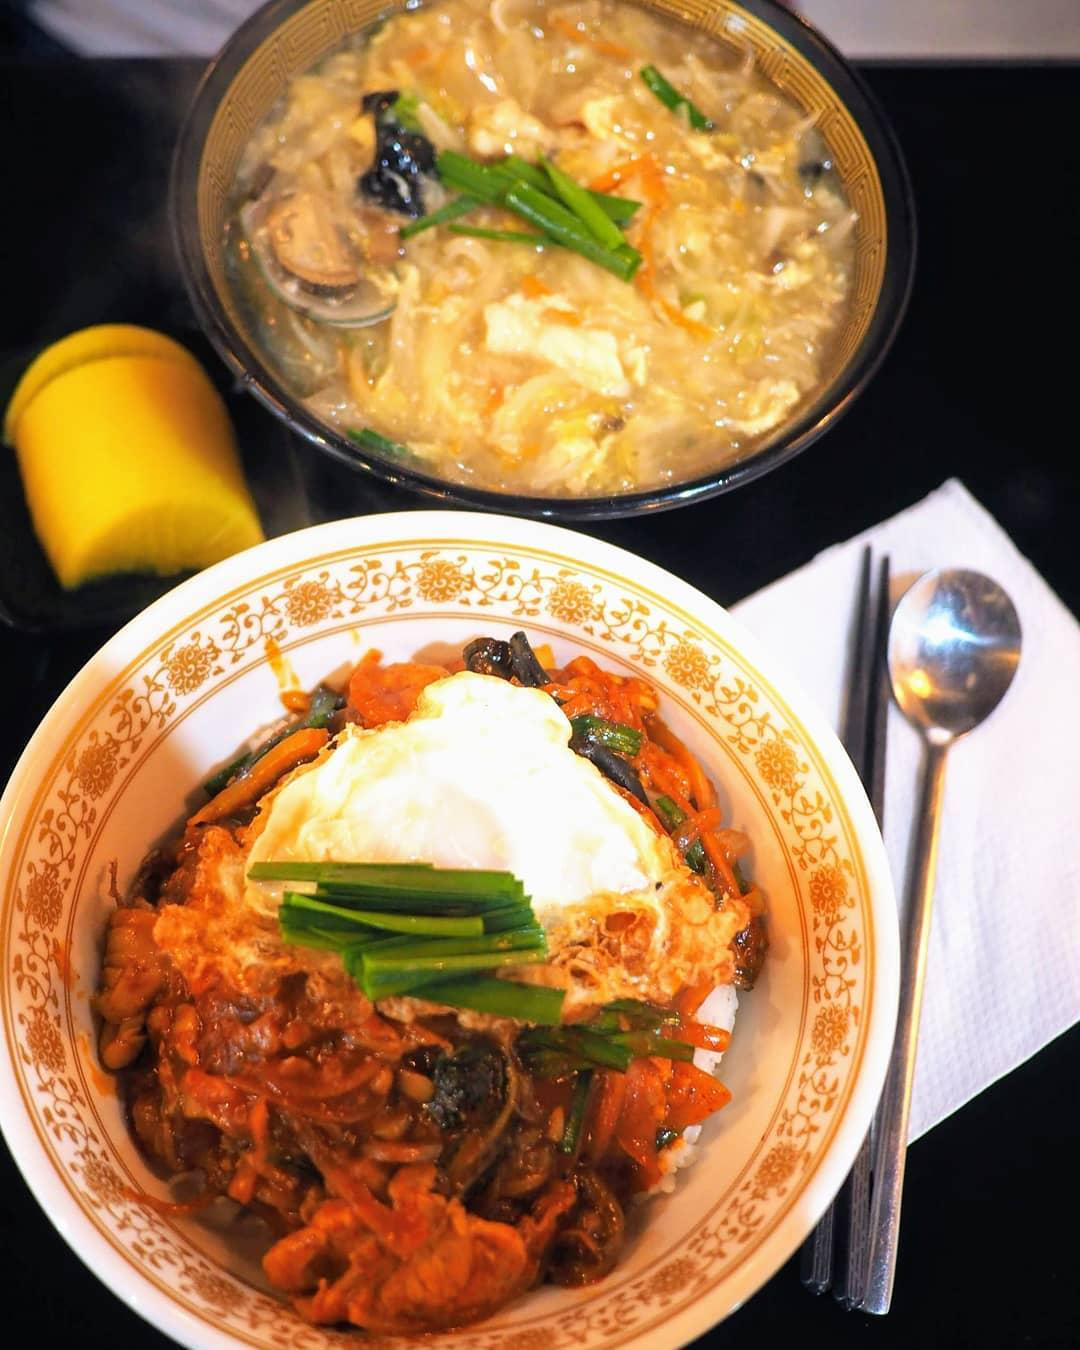

In [52]:
imgzip = zipfile.ZipFile(IMAGE_ZIP)
for name in imgzip.namelist():
    if name.endswith(IMAGE_EXTENSIONS):
        with Image.open(imgzip.open(name)) as img:
            display(img)
            break
del imgzip, name, img

# 2. Embed images
In this section we go over methods to convert our images into a 1D array of numbers (or an N-dimensional vector).

The following are simply examples, and you are more than welcome to adjust the existing code to fit your needs, or to import your own embeddings. The format is a 2D array, where each row is a different image (with the ith row in `embedding` corresponding to the ith filename in `image_filenames`).

The custom functions described in this section can be found in [get_embeddings.py](./get_embeddings.py).

### 2.1 Basic no-batch embedding
The following provides code examples for how to do simple no-batch embedding. This means each image is iterated over individually. This will work in almost all cases, however may not be the most efficient. The `get_embedding` function does utilise multithreading.

The following is an example of how to use the `get_embedding` function. It takes 3 parameters, the two constants defined above, and an `embedding_function`. This function must take in a `PIL.Image` object and return a 1D array of floats (it is crucial that this array is the same length for every image).

The example `embedding_function` provided is `get_normalised_histogram`, but this can be swapped out to whatever you wish as long as it fulfills the above criteria.

(This code is not crucial to the notebook, so you are welcome to comment it out if you do not wish to run it.)

In [54]:
embedding_function = get_normalised_histogram
embedding, image_filenames = get_embedding(image_zip=IMAGE_ZIP, 
                                           image_extensions=IMAGE_EXTENSIONS, 
                                           embedding_function=embedding_function) 
print(embedding[0:5], image_filenames[0:5])
del embedding, image_filenames

100%|██████████| 1000/1000 [00:03<00:00, 308.62it/s]

[[1.48834019e-04 6.85871056e-05 9.05349794e-05 ... 3.26680384e-03
  1.01303155e-03 3.68106996e-03]
 [1.67441460e-02 1.99982782e-02 1.65246212e-02 ... 2.30716253e-03
  3.03891185e-03 1.15487259e-02]
 [1.43001023e-03 4.56660059e-03 3.17415910e-03 ... 1.27893593e-05
  1.51873641e-05 4.55620923e-05]
 [3.26485340e-04 1.25868056e-04 1.27314815e-04 ... 4.74537037e-04
  3.53491512e-04 7.21450617e-04]
 [4.22505144e-02 2.91898148e-02 2.33573388e-02 ... 8.64197531e-04
  4.17524005e-04 1.75154321e-03]] ['images/102654286_3264583356961955_4146541842349978960_n.jpg'
 'images/80131083_262180578535960_4942330824008077400_n.jpg'
 'images/73297222_2569101113327948_4326824972505996829_n.jpg'
 'images/103021040_118504406280091_7992034735412268363_n.jpg'
 'images/105933956_2633613886913246_1614964945471515426_n.jpg']


### 2.2 Batch embedding (pytorch)
The following will describe how to utilise the existing code for pytorch batch embedding. 

This requires a custom dataset class and dataloader (defined below). It is recommended to play with the `DataLoader` parameters to see what runs best. If you use a pytorch embedder other than one of the VGG's (e.g. VGG16/VGG19) you may have to adjust the `ImageDataset` `transform` attribute to resize to an appropriate size with an appropriate mean and std of that embedder.

The cell defining dataset and dataloader must be run, however the one following it is an example implementation of the `get_embeddings_pytorch` function and may be skipped/commented out. 

In [4]:
# Import custom tensor dataset from other file
dataset = ImageDataset(image_zip=IMAGE_ZIP, image_extensions=IMAGE_EXTENSIONS,
                       transform= transforms.Compose([
                           transforms.Resize((224, 224)),  # Resize image to 224x224 pixels
                           transforms.ToTensor(),         # Convert image to tensor
                           transforms.Normalize(          # Normalize using ImageNet statistics
                            mean=[0.485, 0.456, 0.406],  # Mean for RGB channels
                            std=[0.229, 0.224, 0.225]    # Standard deviation for RGB channels
                                )
    ]))

# can look into optimising these values
dataloader = DataLoader(dataset, batch_size=64,
                        shuffle=False, num_workers=0) #,prefetch_factor=2)

This code is commented out by default as 1. It takes a while to run and 2. We will be running it later to produce some of the embeddings.

Note: to adjust the model you may simply swap vgg16 to another pytorch model, listed here: https://pytorch.org/vision/main/models.html
(Please keep in mind the `ImageDataset` `transform`s may need to be changed if you use a non VGG model, so please refer to the documentation for that model.)

In [ ]:
# pytorch_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to("cpu")
# batch_embeddings, image_filenames = get_embeddings_pytorch(dataloader, pytorch_model=pytorch_model)

# print(embedding[0:5], image_filenames[0:5])
# del embedding, image_filenames

### 2.3 Run all embeddings
This cell runs the 4 default embeddings setup for this notebook. You are more than welcome to adjust this. The CLIP embedding is utilising the `imgbeddings` library: https://github.com/minimaxir/imgbeddings


The following cell may be commented out after running once.

In [ ]:
%%time
#### Get embedding without batching ####
embedding_function = get_normalised_histogram
embedding, image_filenames = get_embedding(image_zip=IMAGE_ZIP, image_extensions=IMAGE_EXTENSIONS, embedding_function=embedding_function) 
np.save("./output/image_embedding_hist.npy", embedding)
np.save("./output/image_filenames_hist.npy", image_filenames) # this is to keep a consistent log of the index

#### Get embedding with batching (for pytorch) #####
# https://pytorch.org/vision/main/models/vgg.html
# https://pytorch.org/vision/main/models/generated/torchvision.models.vgg16.html#torchvision.models.VGG16_Weights 

# VGG19
pytorch_model = models.vgg19(weights=models.VGG19_Weights.DEFAULT).to("cpu")
batch_embeddings, image_filenames = get_embeddings_pytorch(dataloader, pytorch_model=pytorch_model)
np.save("./output/image_embedding_vgg19.npy", batch_embeddings)
np.save("./output/image_filenames_vgg19.npy", image_filenames)
# VGG16
pytorch_model = models.vgg16(weights=models.VGG16_Weights.DEFAULT).to("cpu")
batch_embeddings, image_filenames = get_embeddings_pytorch(dataloader, pytorch_model=pytorch_model)
np.save("./output/image_embedding_vgg16.npy", batch_embeddings)
np.save("./output/image_filenames_vgg16.npy", image_filenames)
### Get embedding CLIP (inbuilt batching) #### 
clip_embeddings, image_filenames = get_clip_embedding(IMAGE_ZIP, IMAGE_EXTENSIONS)
np.save("./output/image_embedding_clip.npy", clip_embeddings)
np.save("./output/image_filenames_clip.npy", image_filenames) # this is to keep a consistent log of the index

### 2.4 Load selected embeddings
You may comment and uncomment here selectively to load a specific embedding of your choice. This choice will be used when walking through helper functions and visualisations in this notebook.
Please note at the end of this notebook there is an option to either generate an output HTML file for just the embedding selected here, or for any number of them at once. If you opt for the second option and don't wish to see examples, you may skip to the end of the notebook from here.

In [22]:
%%time
#### Load Embeddings ####
## Colour Histogram ##
embedding = np.load("./output/image_embedding_hist.npy")
image_filenames = np.load("./output/image_filenames_hist.npy")
## VGG16 ##
# embedding = np.load("./output/image_embedding_vgg16.npy")
# image_filenames = np.load("./output/image_filenames_vgg16.npy")
## VGG19 ##
# embedding = np.load("./output/image_embedding_vgg19.npy")
# image_filenames = np.load("./output/image_filenames_vgg19.npy")
## CLIP ##
# embedding = np.load("./output/image_embedding_clip.npy")
# image_filenames = np.load("./output/image_filenames_clip.npy")


CPU times: user 1.12 ms, sys: 6.16 ms, total: 7.28 ms
Wall time: 16.6 ms


# 3. Embedding Analysis
In this section we will define some functions to help us analyse the image embeddings. The custom functions described in this section can be found in [embeddings_analysis.py](./embeddings_analysis.py).

### 3.1 Get KNN
In this section we generate the `nearest_neighbours_array` and `neighbours_distance_array` for the desired `number_of_neighbours`. 
The `nearest_neighbours_array` is a 2D array where the ith row represents the ith filename in `image_filenames`, and each row lists the desired N nearest neighbours for that specific image.
The `neighbours_distance_array` is similar to the `nearest_neighbours_array`, however lists the neigbour distance.

Below is an example implementation, you may choose to cache these files, however it shouldn't take too long to run.

In [23]:
%%time
number_of_neighbours = 10
nearest_neighbours_array, neighbours_distance_array = get_knn(embedding, number_of_neighbours)
## Save ##
# np.save(f"./output/{number_of_neighbours}_nearest_neighbours.npy", nearest_neighbours_array)
# np.save(f"./output/{number_of_neighbours}_nearest_neighbours_distance.npy", neighbours_distance_array)
## Load ##
# number_of_neighbours_load = 10
# nearest_neighbours_array = np.load(f"./output/{number_of_neighbours_load}_nearest_neighbours.npy")
# neighbours_distance_array = np.load(f"./output/{number_of_neighbours_load}_nearest_neighbours_distance.npy")
nearest_neighbours_array[0:3], neighbours_distance_array[0:3]

CPU times: user 99 ms, sys: 34.9 ms, total: 134 ms
Wall time: 88 ms


(array([[  0, 167, 406, 453, 703, 989, 751, 699, 861,  23],
        [  1, 485, 480, 967, 583, 561, 879, 470, 298, 987],
        [  2, 682, 849, 478, 264,   9, 990, 621, 984, 254]], dtype=int32),
 array([[0.        , 0.13286416, 0.13353139, 0.14186984, 0.14380419,
         0.14445083, 0.14460635, 0.14561445, 0.14817175, 0.14845143],
        [0.        , 0.04409279, 0.05827649, 0.06201542, 0.06250096,
         0.06344182, 0.0645036 , 0.06547838, 0.06623742, 0.06712245],
        [0.        , 0.03847718, 0.04065615, 0.04128346, 0.04224772,
         0.0427824 , 0.04367463, 0.04437153, 0.04457691, 0.044742  ]],
       dtype=float32))

### 3.2 Make some analysis helper functions
The first helper function is `get_count_neighbour_occurances`. This function takes the `nearest_neighbour_arary` and returns an array where the ith index is how many times that index appeared as a neighbour (including as a neighbour of itself).

In [26]:
count_neighbour_occurance_array = get_count_neighbour_occurances(nearest_neighbours_array=nearest_neighbours_array)
count_neighbour_occurance_array[0:10]

array([ 2, 21, 41,  4,  4, 29, 12,  2,  5, 25])

Next up we have `rank_neighbour_occurances`, which takes the previously defined `count_neighbour_occurance_array` as an input, and returns an array where the ith value in the array indicates that the index stored there is the ith most common or ith least common neighbour, depending on if the `ascending` parameter is set to `True` or `False` (`True` by default).

In [ ]:
ranked_neighbour_occurance_array = rank_neighbour_occurances(count_neighbour_occurance_array, ascending=True)
print(f"The most common neighbour is at image_filenames index {ranked_neighbour_occurance_array[-1]}") # The last value as ascending
ranked_neighbour_occurance_array[0:10]

The most common neighbour is at image_filenames index 176


array([499, 531, 517, 508, 502, 115, 487, 549, 461, 447])

`get_mean_distance` takes in the previously described `neighbours_distance_array` and returns a 1D array where the ith index indicates the ith images mean distance from all of its N nearest neighburs. You may choose whether this calculation should include itself as a neighbour (as each image is always its own closest neighbour) by setting the boolean value of `exclude_self` (`True` by default).

In [30]:
get_mean_distance(neighbours_distance_array, exclude_self=True)[0:10]

array([0.14259605, 0.06151881, 0.04253466, 0.07726505, 0.07184123,
       0.04206987, 0.07548728, 0.12076729, 0.09519671, 0.04260647],
      dtype=float32)

### 3.2 Getting K-means clusters
These will be used as an additional visualisation option for the images.

The `get_cluster_labels` function takes in `embedding` (the image embedding array) and `n_clusters` (desired number of clusters, by default 10). If you wish you may also change the `random_state`. This function returns a 1D array, where the ith index indicates what cluster the ith image lies in. (e.g. 0th cluster, 1st cluster...)

In [10]:
%%time
cluster_labels = get_cluster_labels(embedding, n_clusters=20)
cluster_labels[0:10]

CPU times: user 507 ms, sys: 15.8 ms, total: 523 ms
Wall time: 111 ms


array([ 7, 12,  0,  0,  7,  0,  7,  7,  0,  0], dtype=int32)

# 4. Data exploration
This following section aims to serve as an example of some visualisation options. Feel free to add your own here. 


First, lets graph the most common neighbours

### 4.1 Most common neighbours

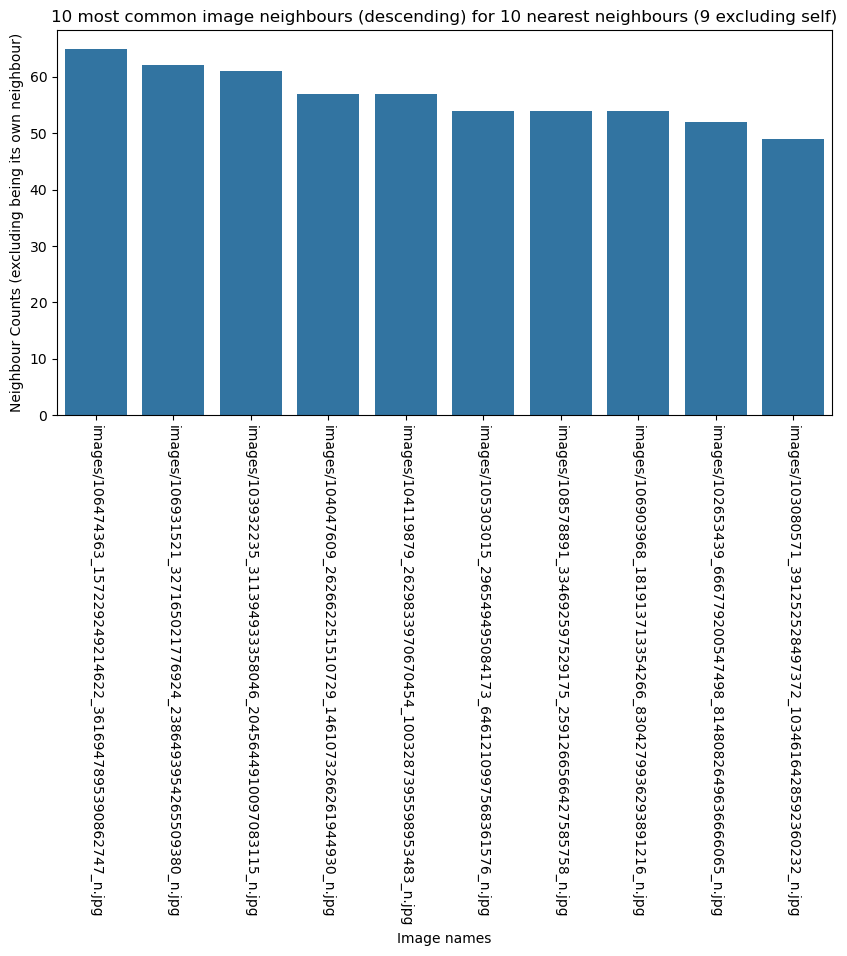

images/106474363_157229249214622_3616947895390862747_n.jpg


In [ ]:
count_neighbour_occurances_array = get_count_neighbour_occurances(nearest_neighbours_array)
ranked_neighbour_occurances = rank_neighbour_occurances(count_neighbour_occurances_array, ascending=False)

n_most_common = 10
x=[image_filenames[idx] for idx in ranked_neighbour_occurances[0:n_most_common]]
y=[count_neighbour_occurances_array[idx] -1 for idx in ranked_neighbour_occurances[0:n_most_common]] # the -1 is to exclude counting being its own neighbour
del count_neighbour_occurances_array, ranked_neighbour_occurances
plt.figure(figsize=(10,5))

sns.barplot(x=x, y=y)

plt.xticks(rotation=270)
plt.xlabel("Image names")
plt.ylabel("Neighbour Counts (excluding being its own neighbour)")
plt.title(f"{n_most_common} most common image neighbours (descending) for 10 nearest neighbours (9 excluding self)")

plt.show()
print(x[0]) # the filename for the most common image 

Display the most common image neighbour.

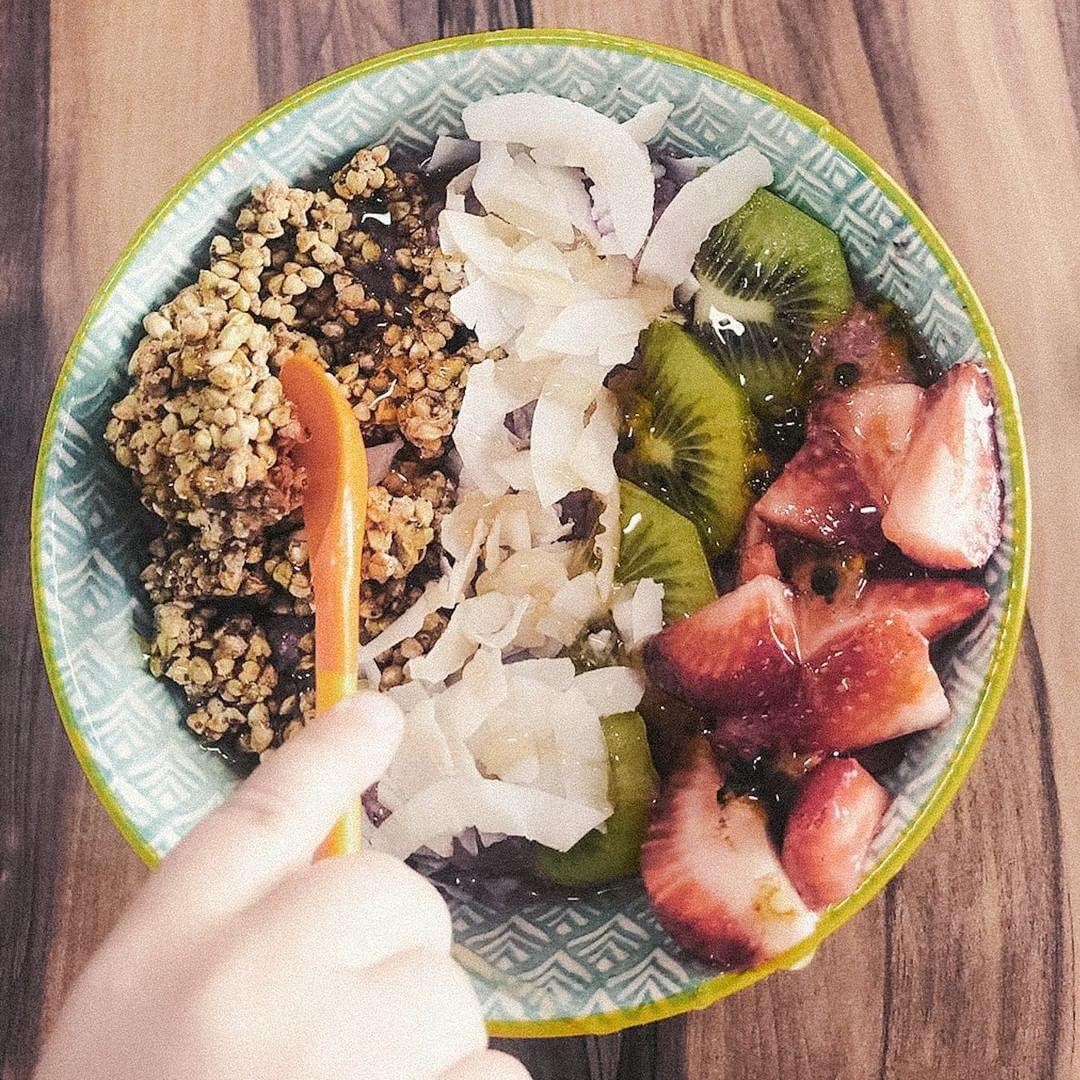

In [46]:
imgzip = zipfile.ZipFile(IMAGE_ZIP)
with Image.open(imgzip.open(x[0])) as img:
    display(img)

### 4.2 Closest image to its neighbours (average)

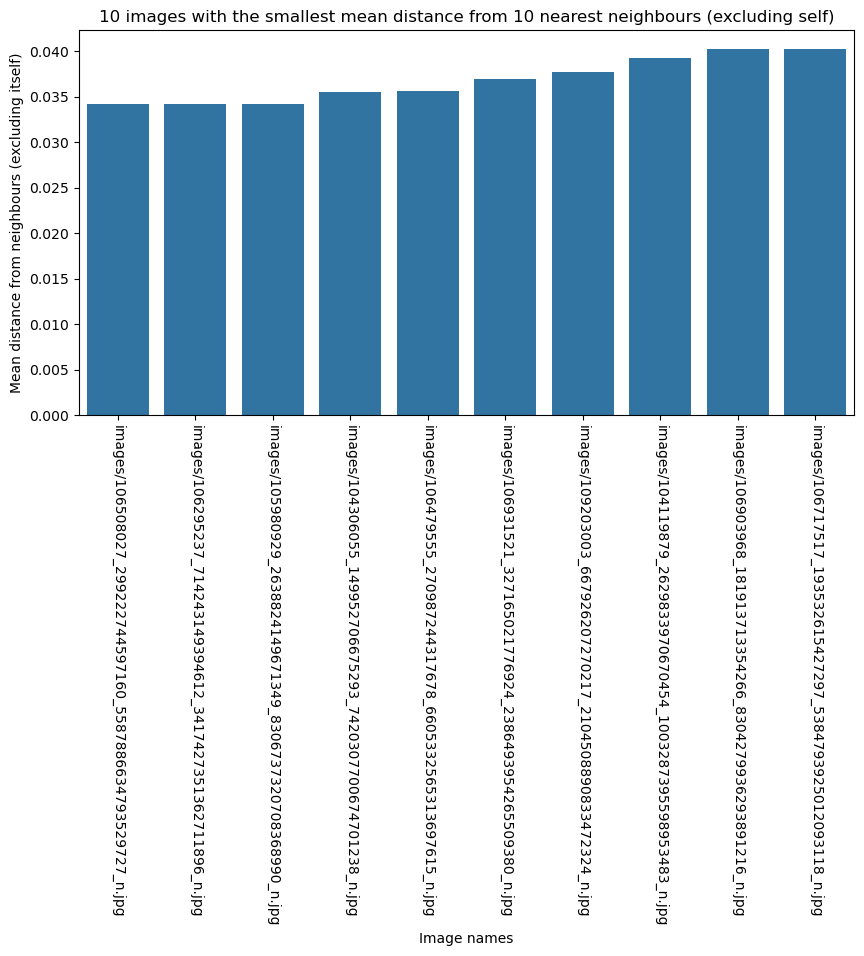

images/106508027_299222744597160_5587886634793529727_n.jpg


In [47]:
neighbours_mean_distance_array = get_mean_distance(neighbours_distance_array)
ranked_neighbour_occurances = rank_neighbour_occurances(neighbours_mean_distance_array, ascending=True)

n_most_common = 10
x=[image_filenames[idx] for idx in ranked_neighbour_occurances[0:n_most_common]]
y=[neighbours_mean_distance_array[idx] for idx in ranked_neighbour_occurances[0:n_most_common]] # the -1 is to exclude counting being its own neighbour
del neighbours_mean_distance_array, ranked_neighbour_occurances
plt.figure(figsize=(10,5))

sns.barplot(x=x, y=y)

plt.xticks(rotation=270)
plt.xlabel("Image names")
plt.ylabel("Mean distance from neighbours (excluding itself)")
plt.title(f"{n_most_common} images with the smallest mean distance from 10 nearest neighbours (excluding self)")

plt.show()
print(x[0])

Display the closest image neighbour.

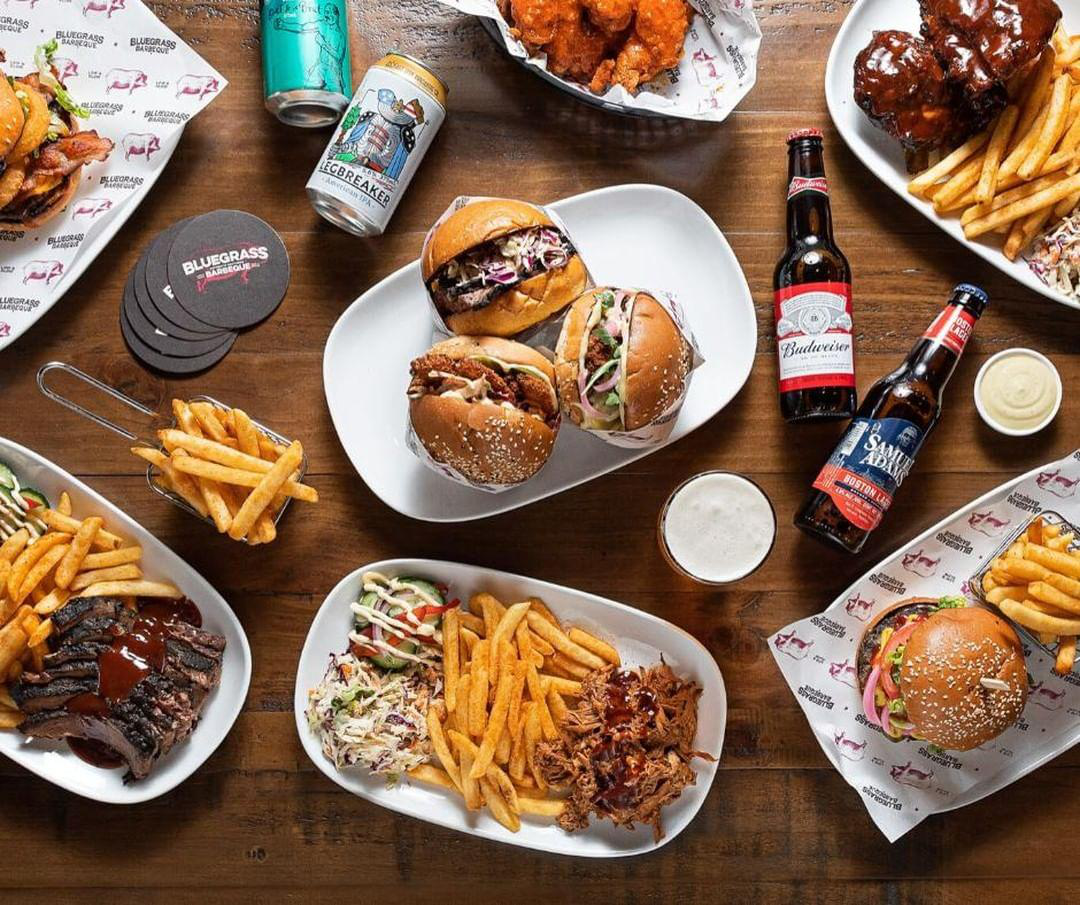

In [48]:
imgzip = zipfile.ZipFile(IMAGE_ZIP)
with Image.open(imgzip.open(x[0])) as img:
    display(img)

### 4.3 Histogram for times an image appears as a nearest neighbour
This graph is worth noting in particular for different embeddings, some have much more even distributions than others.

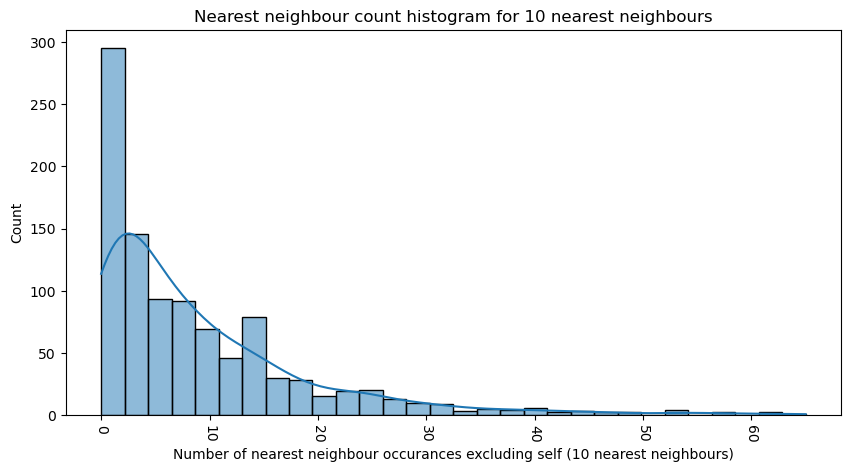

In [13]:
sorted_count_neighbour_occurances_array = np.sort(get_count_neighbour_occurances(nearest_neighbours_array))-1 # -1 to exclude self

plt.figure(figsize=(10,5))

sns.histplot(x=sorted_count_neighbour_occurances_array, kde=True, bins=30)
plt.xticks(rotation=270)
plt.xlabel(f"Number of nearest neighbour occurances excluding self ({number_of_neighbours} nearest neighbours)")
plt.ylabel("Count")
plt.title(f"Nearest neighbour count histogram for {number_of_neighbours} nearest neighbours")

plt.show()
del sorted_count_neighbour_occurances_array


### 4.4 Histogram for an images mean distance across its neighbours

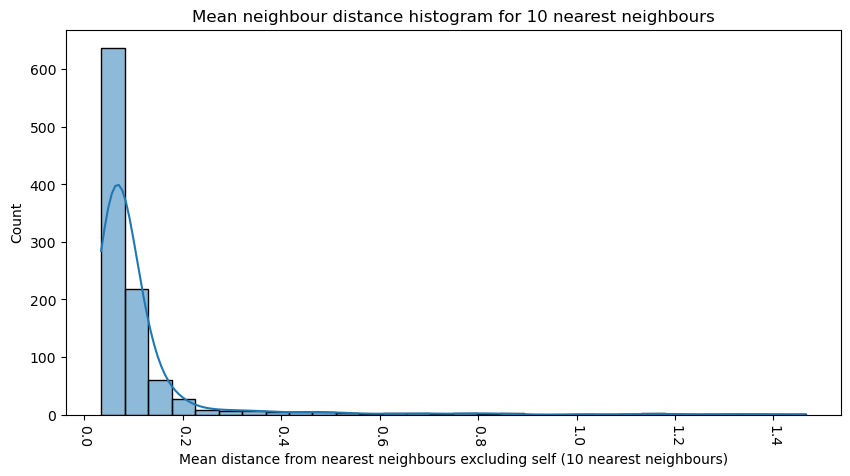

In [32]:
log = False

if log:
    sorted_mean_distance_array = np.log(np.sort(get_mean_distance(neighbours_distance_array)))
    title = "Log mean"
else:
    sorted_mean_distance_array = np.sort(get_mean_distance(neighbours_distance_array))
    title = "Mean"

plt.figure(figsize=(10,5))

sns.histplot(x=sorted_mean_distance_array, kde=True, bins=30)

plt.xticks(rotation=270)
plt.xlabel(f"{title} distance from nearest neighbours excluding self ({number_of_neighbours} nearest neighbours)")
plt.ylabel("Count")
plt.title(f"{title} neighbour distance histogram for {number_of_neighbours} nearest neighbours")

plt.show()
del sorted_mean_distance_array

### 4.5 Visualise the embeddings for the most and least common nearest neighbours

A bar graph to physically view the differences between the most and least common image neighbours. Please note these graphs don't always work due to handling of extreme values.

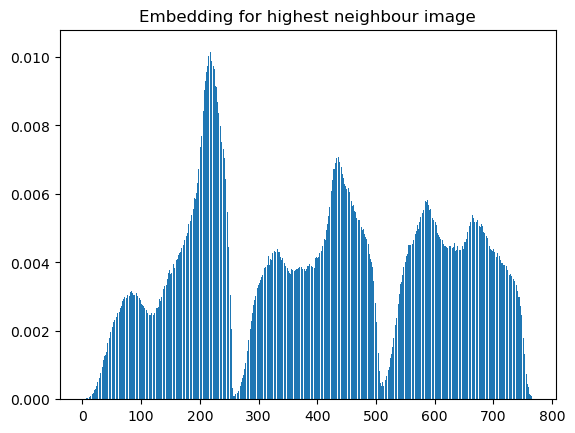

images/106474363_157229249214622_3616947895390862747_n.jpg


In [ ]:
count_neighbour_occurances_array = get_count_neighbour_occurances(nearest_neighbours_array)
max_index = np.argmax(count_neighbour_occurances_array)

plt.bar(np.arange(len(embedding[max_index])), embedding[max_index])
plt.title("Embedding for highest neighbour image")
plt.show()
print(image_filenames[max_index])

In [50]:
min_index = np.argmin(count_neighbour_occurances_array)

plt.bar(np.arange(len(embedding[min_index])), embedding[min_index])
plt.title("Embedding for lowest neighbour image")
plt.show()
del count_neighbour_occurances_array
print(image_filenames[min_index])

images/104114463_296892185020297_5974708626890371105_n.jpg


### 4.6 Force directed diagram code
This section was originally to create an interactive "network plot" with a heatmap for aid in visualisation, using different colours for each points cluster. 

The code for viewing these plots can be seen commented out in [force_directed_diagram.py](./force_directed_diagram.py), however the same visualisation will be avaliable in the output html documents at the end of this notebook (**this is the recommended way to view these graphs**).

The example code shown in this section is use to create the diagrams for the output html file. 

The `get_diagram_data` function returns all the data needed to construct the force directed diagram, taking in a variety of previously defined data. Setting `return_json` to `True` will return a string (this is used for generating the HTML).

In [ ]:
diagram_data = get_diagram_data(nearest_neighbours_array, neighbours_distance_array, cluster_labels, image_filenames, return_json=False)
print(diagram_data.keys()) # showing keys as the actual dictionary is very large
del diagram_data

dict_keys(['grid', 'Z', 'x', 'y', 'index', 'rgba_colours', 'image_filenames'])

### 4.7 Pie chart for images in each cluster
This chart was created to help visualise the differences in cluster sizes.

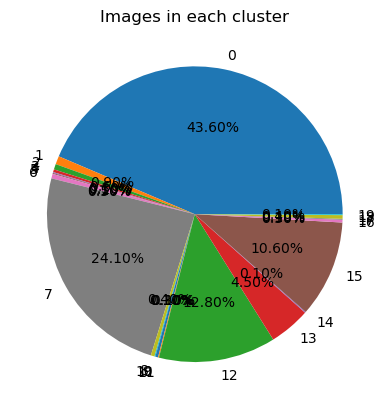

In [55]:
labels, counts = np.unique(cluster_labels, return_counts=True) 

plt.pie(counts, labels=labels, autopct='%.2f%%')
del labels, counts
plt.title("Images in each cluster")
plt.show()

# 5. HTML Export 
Create a "summary" HTML document. What this document contains is better described within the file. If running in binderhub, please right click + `Open in New Browser Tab` the html file to ensure the javascript runs as expected. 

The main options are the following: `colour_map` is set to `"tab20"` by default but it may be set to any of the options avaliable when running `from matplotlib import colormaps` and `list(colormaps)` (for over 20 clusters you would need to use a continous map like `"viridis"`).

You may also select if you would like your images to be grouped by cluster when displayed. The `group_cluster` parameter has the following options:
- `False`: Sort by rank normally
- `True`: Order by Cluster label order
- `asc`: Sort by ascending cluster size order
- `desc`: Sort by descending cluster size order
- `rank`: Sort by the highest ranked image in each cluster

Please note the HTML is fully self contained, meaning after it is created it has the images and required packages encoded within it. This is so the HTML can be easily shared, and will still be runnable without internet access.

The custom functions described in this section can be found in [get_html.py](./get_html.py).

The following cell is to create a single HTML file using the previously run cells. When not using I recommend commenting it out to prevent accidental running.

In [58]:
# %%time
# diagram_data = get_diagram_data(nearest_neighbours_array, neighbours_distance_array, cluster_labels, image_filenames, return_json=False)

# html_file = generate_html(nearest_neighbours_array, neighbours_distance_array, IMAGE_ZIP, IMAGE_EXTENSIONS, diagram_data, cluster_labels, group_clusters=False)

# with open("./output/output.html",'w') as file:
#     file.write(html_file)

# del html_file, diagram_data, file

The following generates a html file for each embedding in `embedding_name_list`. Note that the name in `embedding_name_list` refers to the name used when saving the embedding + image_filenames.

This cell can be run immediately after saving the embeddings, and does not require any of the cells inbetween. When not using I recommend commenting it out to prevent accidental running. 

In [ ]:
%%time

# Please ensure that the embeddings have been created for all embeddings in the list
embedding_name_list = ['hist','clip', 'vgg19','vgg16']
number_of_neighbours=10
n_clusters=20
group_clusers=False
colour_map="tab20"

for embedding_name in embedding_name_list:
    html_file = generate_html(*get_html_rendering_details(embedding_name, IMAGE_ZIP, IMAGE_EXTENSIONS, number_of_neighbours=number_of_neighbours, n_clusters=n_clusters), 
            group_clusters=group_clusers, 
            colour_map=colour_map)

    with open(f"./output/output_{embedding_name}.html",'w') as file:
        file.write(html_file)
        del html_file, file

    print(f"Completed export for {embedding_name}")

Completed export for hist
Completed export for clip
Completed export for vgg19
Completed export for vgg16
CPU times: user 1min 33s, sys: 3.42 s, total: 1min 37s
Wall time: 1min 36s


## Observations

- You can change the amount of clusters for different advantages 
    - Lower neighbours will create more branches, as it isolates small "groups"
    - Higher neighbours will be more central, but accentuate the very different groups 

- interestingly across the board the clusters don’t seem to be significant predictors of location on the force directed diagram, they appear to largely capture different things. This may be due to a lack of clusters.
- Overall, VGG16 and CLIP tend place pizza, burgers, “documents” (like menus, text ads), and furniture by themselves on their own 'branches'.

histogram:
- the mean distance histogram appears constantly decreasing 
- images with a similar amount of all types of pixels appear to have more neighbours than ones that are colour dominated
- the force directed diagram is centralised with two branches, the lower branch seems to be images that are white dominated, and the upper branch has a cluster of images with black backgrounds and yellow text!
- there is a more minor branch going down that has images with black backgrounds and white text, and navy backgrounds with white text
- the nearest neighbour count histogram is fairly uneven
- Some clusters are very explicit:
    - 9: pastel pink dominated
    - 8: Black and blue dominated
    - 6: very white dominated
    - 5: navy dominated
    - 4: "lime green" dominated 
    - 3: pure black and white
    - 2: primarily black and yellow
    - 1: Images with lots of white but a good mix of other colours

VGG16:
- images with a more uniform probability distribution tend to appear more as a nearest neighbour, meaning things that vgg16 classifies as 'definitely one thing' tend to appear less as neighbours

- much more uneven 10 smallest mean distance
- extremely uneven nearest neighbour count histogram
- fairly normal mean distance histogram with a spike in the smallest bin

- “Spider-like” force directed diagram (lots of legs branching from a central hub)
    - one arm (prominent bottom left) consists of people holding cups
    - arm (bottom right) largely of rectangles with writing (e.g. informative images, menus, etc.)
    - arm (vertical up) largely top down view of dishes with a central brown-dominated food
    - arm (top right) food centred on a proportionately quite large white plate
    - arm (centre right) ice cream/dessert looking foods
    - arm (top left) “hot pot” looking foods in black bowls/cooking pots

- Cluster features:
    - 0: white furniture
    - 1: mostly white rectangles with text (not photos but computer graphics)
    - 5: burgers
    - 7: pizza
    - 8: food in black bowls
    - 9: hot dog-ish foods


CLIP:
- it seems that images with “more things going on” seem to have more neighbours, this may have something to do with the patches that CLIP creates
- Very even 10 smallest mean distance graph
- Unbalanced nearest neighbour count graph
- “Normal” looking mean neighbour distance graph

- looking at the embedding graph, the highest and lowest neighbours appear to have 3 major spikes in the same places, and look quite similar. (this tracks with the even mean distance graph)
- force directed diagram is quite central with 4 large spikes
    - bottom left: pizza
    - bottom central: burgers
    - central right: “sheets with text” computer graphics
    - upper right: white/gray furniture photos

- Cluster features
    - 0: Tables, chairs, and drawers/dressers
    - 1: “flat” images with text (like things made in canva)
    - 3: Desserts/pastries
    - 5: Often things with two dishes (two plates, a plate and a cup) etc.
    - 6: every photo has a person or dog (or something that could be mistaked for the above)
    - 7: Burgers
    - 8: People holding things (or photos with one "thing" in them)
    - 9: Mostly Coffee (and a couple other drinks)

- Note: CLIP Very strongly put photos with a person or dog in one cluster (and had a different cluster for people holding things). It seems like CLIP has been trained on a lot more photos of people than VGG16. Clip is also much “better” at putting things together, VGG16 in the burger cluster had a lot more things that looked like burgers but weren’t burgers.
- the CLIP clusters tended to be much more differentiable to the eye than the VGG16 ones, it. It has clearly been trained on things like burgers, humans, dogs, hands, and coffee

## Notes to self

### make visualisation of the dimension values for top neighbour vs bottom

is the nearest neighbour graph of a specific set of images and embeddings a useful way for navigating/making sense of a dataset



1. histogram for counts of neighbours ✅
2. make a html document with image, number of nearest neighbours, sorted from top to bottom ✅

Embeddings:
- vgg (16) (see if specific package just for vgg) ✅
- check papers sent (single layer feature networks)
- surf feature extractor (implementation in scikit image)
- clip 

constraints:
- needs to run on windows (no tensorflow?)
- pytorch based things? (pytorch cpu backend)
- need to work on cpu + not be slow
- ~~ coffee break to do initial processing (5-15 for 20 000) (everything else can be interactive so can sit and wait)
- embedding step is linear, knn is ^1.1ish

one of the 

use np standard to write the embedded array and KNN array and the filename array ✅

ideas:
- can do a colour coded histogram for count of neighbours with multiple types of embeddings

Experiment with batching first and see how much it helps, see if it takes advantage of multiple threads natively

1. performance comparison between clip and vgg
2. note other experiments and return next week 
3. start exploring different visualisations with KNN graph

    a. select an image and see the nearest neighbours of the image
    
    b. experiment before and loop into heaps and other image display things

1. seriation and clustering (look into displays for clutering, cluster number and different table backgrounds)
2. experiment with networks + more displays like % neighbours bar 
3. keep going through different embeddings, write down different notes/observations with different embeddings (stuff with clip being more even distr than)

Presentation:
- 5 min on introductions (where everyone works and what they are intersted in)
- preamble to set the scene, why this projects
- I give an overview of what I've done so far, general architecture, discuss different experiments, end with html index
    - Talk through the components 

- Ask if this is something that might be useful in general
- Ask what kind of workflow makes sense
    - What kind of images and where
    - Where is the data stored

- Would you be able to test out a notebook in the next few weeks?


- what import format
- what to consider and where
- what output format and where

- select the embedding type in html

Look into ipy widgets for selecting embeddings etc.https://ipywidgets.readthedocs.io/en/stable/
https://github.com/Australian-Text-Analytics-Platform/discursis
- look up binderhub (make sure dependencies preinstalled)
    - requirements.txt at root of repository 
    

1. add network graph into html
2. get selection to work properly
3. way to select embedding
4. set up requirements.txt and prepare for binderhub
5. Set up and test in binderhub

Look into downloading it:   <script src="https://cdn.jsdelivr.net/npm/plotly.js-dist-min"></script>

- figure out how to load images into the html file
    - Save smaller res 
    - Optimise storage with regards to grid view (can you index one list)
    - look into installing cpu only nvidia

- Make it user friendly 


Ideas for html text:

Nearest Neighbour Image visualisation

Welcome! 

Components:
1. force directed diagram 
    - A visualisation based off of embedding distances and K nearest neighbours.
    - Includes a KDE plot to aid in visualising density
    - Points can be hovered over to display their image index
    - Different point colours represent different clusters
    - **Groups of points can be selected to be displayed on the grid, and to filter the image table.**
2. Image grid
    - Displays the last selected images 
    - Can scroll to view all images when many are selected
3. Image table
    - Display ranking in list of reverse nearest neighbours, and index and cluster displayed in a way to be easy to find with COMMAND FIND 
    - Number of reverse nearest neighbours and percentage fill for easy visualisation
    - Mean distance to all nearest neighbours and percentage fill for easy visualisation
    - image filename
    - List of K nearest neighbours with clickable links
    - Thumbnail of image 

Options:
- SEARCH FOR IMAGES OR CLUSTERS WITH COMMAND FIND AND () [] respectively
- Compare this documents look with different embeddings
- Compare this documents look with different amounts of nearest neighbours + clusters
- Group by Cluster
    - Size of cluster (<code>asc</code>/<code>desc</code>)
    - Highest rank in cluster
- Encode data into html document (increases size but allows it to be used standalone)


image upload:
- flat zipped image file
- flat zipped folder with mixture of images and non images
- nested folders of images (zipped + unzipped)
- nested folders where only some should be included
start with first one and progress, **test with 10 image dataset**

work on making the code nicer and structured

put the template in a .txt

consider where to go in terms of keeping large diagrams
- should become clearer with writing

- consider zipping output folder

https://discuss.pytorch.org/t/training-crashes-due-to-insufficient-shared-memory-shm-nn-dataparallel/26396/7